<a href="https://colab.research.google.com/github/heewonLEE2/Data-Ai-Colab/blob/main/RoadSignDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **객체 탐지(Object Detection) 실습**

### YOLOv8 기반 도로 표지판 탐지 모델 학습

📚 **학습 목표**
- Kaggle의 도로 표지판(Road Sign) 데이터셋을 활용하여
YOLOv8(Object Detection) 모델을 직접 학습
- 학습된 모델로 표지판 이미지 객체 탐지 결과를 확인하는 것이 목표
- 사용한 데이터셋 링크
    - 🔎 https://www.kaggle.com/datasets/andrewmvd/road-sign-detection

## **1. 데이터셋 나누기**

In [ ]:
!unzip -q RoadSign.zip

1.   다운받은 데이터셋을 압축 풀어준 뒤 train과 test 데이터셋 나누기
2.   데이터 분할 (Train: 80%, Test: 20%)

In [ ]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

# 1. 경로 설정 (사용자 환경인 /content 기준)
base_path = Path('/content')
src_img_dir = base_path / 'images'          # 원본 이미지 폴더
src_label_dir = base_path / 'annotations'   # 원본 라벨 폴더 (.xml)
dst_root = base_path / 'roadsign_datasets' / 'voc'

# 2. 이미지 파일 리스트 가져오기
# (확장자가 여러 개라면 glob 패턴을 추가하거나 리스트를 합쳐야 합니다)
image_files = sorted(list(src_img_dir.glob('*.png'))) + sorted(list(src_img_dir.glob('*.jpg')))

# 이미지 개수 확인 (디버깅용)
print(f"총 발견된 이미지 개수: {len(image_files)}장")

# 3. 데이터 분할 (Train: 80%, Test: 20%)
# random_state=42: 언제 실행해도 똑같은 세트로 나뉩니다.
if len(image_files) > 0:
    train_imgs, test_imgs = train_test_split(image_files, test_size=0.2, random_state=42)
else:
    print("이미지 파일이 없습니다. 경로를 확인해주세요.")
    train_imgs, test_imgs = [], []

def copy_data(file_list, split_name):
    """
    이미지 리스트를 받아 해당 split(train/test) 폴더로
    이미지와 대응되는 .xml 파일을 복사합니다.
    """
    # 목적지 폴더 경로 생성
    save_img_dir = dst_root / 'images' / split_name
    save_label_xml_dir = dst_root / 'labels_xml' / split_name

    # 폴더 생성 (exist_ok=True로 이미 있어도 에러 안 나게 처리)
    save_img_dir.mkdir(parents=True, exist_ok=True)
    save_label_xml_dir.mkdir(parents=True, exist_ok=True)

    copy_count = 0

    for img_path in file_list:
        file_stem = img_path.stem  # 확장자 뺀 파일명 (예: road_01)

        # A. 이미지 복사
        shutil.copy(img_path, save_img_dir / img_path.name)

        # B. XML 라벨 복사
        # annotations 폴더에서 [파일명.xml]을 찾습니다.
        xml_file = src_label_dir / f"{file_stem}.xml"

        if xml_file.exists():
            shutil.copy(xml_file, save_label_xml_dir / f"{file_stem}.xml")
            copy_count += 1
        else:
            # 이미지는 있는데 라벨(xml)이 없는 경우 경고 출력
            print(f"[Warning] XML 없음: {file_stem}")

    print(f"[{split_name}] 이미지 {len(file_list)}장, 라벨 {copy_count}개 복사 완료")

# 4. 실행
if len(image_files) > 0:
    print("데이터 복사를 시작합니다...")
    copy_data(train_imgs, 'train')
    copy_data(test_imgs, 'test')
    print("모든 작업이 완료되었습니다.")

총 발견된 이미지 개수: 877장
데이터 복사를 시작합니다...
[train] 이미지 701장, 라벨 701개 복사 완료
[test] 이미지 176장, 라벨 176개 복사 완료
모든 작업이 완료되었습니다.


## **2. xml 형식의 annotation을  YOLO가 필요로한 txt 형식으로 변경**


### 1. https://github.com/ssaru/convert2Yolo.git clone을 받아 진행! 해당 github로 가면 가이드가 나와있다

In [ ]:
# 어노테이션을 YOLO 형식으로 변환하기 위한 git clone
!git clone https://github.com/ssaru/convert2Yolo.git

Cloning into 'convert2Yolo'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 215 (delta 38), reused 35 (delta 35), pack-reused 172 (from 1)
Receiving objects: 100% (215/215), 994.67 KiB | 3.95 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
# clone한 경로로 이동한 후
%cd convert2Yolo/

/content/convert2Yolo


In [ ]:
%pip install -r requirements.txt # 코드 실행에 필요한 의존성파일을 다운로드

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 14.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
save_convert_train_labels = dst_root / 'labels' / 'train'
save_convert_test_labels = dst_root / 'labels' / 'test'

save_convert_train_labels.mkdir(parents=True, exist_ok=True)
save_convert_test_labels.mkdir(parents=True, exist_ok=True)

### 2. label과 convert_output_path등을 설정한 다음 convert 진행

In [ ]:
!python example.py \
    --datasets VOC \
    --img_path /content/roadsign_datasets/voc/images/train \
    --label /content/roadsign_datasets/voc/labels_xml/train \
    --convert_output_path /content/roadsign_datasets/voc/labels/train \
    --img_type '.png' \
    --manifest_path /content/roadsign_datasets \
    --cls_list_file ./roadSign.names


VOC Parsing:   |████████████████████████████████████████| 100.0% (701/701)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (701/701)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (701/701)  Complete



In [ ]:
!python example.py \
    --datasets VOC \
    --img_path /content/roadsign_datasets/voc/images/test \
    --label /content/roadsign_datasets/voc/labels_xml/test \
    --convert_output_path /content/roadsign_datasets/voc/labels/test \
    --img_type '.png' \
    --manifest_path /content/pascal_datasets \
    --cls_list_file ./roadSign.names


VOC Parsing:   |████████████████████████████████████████| 100.0% (176/176)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (176/176)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (176/176)  Complete



# **3. YOLO 모델을 import한 뒤 학습 시작**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO('yolov8s.pt')

In [ ]:
%pwd

'/content/convert2Yolo'

### 1. 학습을 진행하면 run 폴더가 현재 내가 위치한 디렉토리에 생긴다. roadsign_datasets에 저장하고 싶어서 이동 후 yaml파일을 data에 넣어주어 실행

```
* 10 epoch 결과 꽤나 잘 맞춘거 같다

Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.3s/it 3.9s
                   all        176        260      0.909      0.882      0.905       0.75
          trafficlight         23         44      0.829      0.682      0.731      0.521
                  stop         28         28      0.903      0.995      0.973       0.87
            speedlimit        124        141      0.975      0.993       0.99      0.876
             crosswalk         41         47      0.931      0.857      0.926      0.733
```

In [ ]:
%cd /content/roadsign_datasets

/content/roadsign_datasets


In [ ]:
results = model.train(
    data='/content/roadsign_datasets/roadSign.yaml',
    epochs=10,
    batch=32,
    imgsz=640,
    device=0,
    workers=2,
    name='custom_s'
)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/roadsign_datasets/roadSign.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=custom_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

### 2. 학습이 진행뒤 저장된 best.pt를 model에 적용시킨뒤 val 진행

```
* val 에서도 꽤나 좋은 결과가 나온것 같다

val: Scanning /content/roadsign_datasets/voc/labels/test.cache... 176 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 358.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.2it/s 4.9s
                   all        176        260      0.918      0.875      0.912       0.75
          trafficlight         23         44      0.866      0.682      0.762      0.526
                  stop         28         28      0.901      0.964      0.967      0.865
            speedlimit        124        141      0.972      0.993       0.99      0.877
             crosswalk         41         47      0.931      0.861      0.927      0.733

```

In [ ]:
# 학습된 모델 로드
model = YOLO("runs/detect/custom_s/weights/best.pt")

# 검증 수행
results = model.val(
    data="/content/roadsign_datasets/roadSign.yaml",  # 데이터셋 설정
    imgsz=640,               # 이미지 크기
    iou=0.5,                 # IoU 임계값
    batch=32,                # 배치 크기
    device=0,                # GPU 사용
    workers=2,               # 데이터 로드 시 병렬 처리할 워커 수
    half=True,               # FP16 연산 활성화 (속도 향상)
    split="val"             # val2007 데이터셋을 사용
)

print(results)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2006.4±905.2 MB/s, size: 214.5 KB)
val: Scanning /content/roadsign_datasets/voc/labels/test.cache... 176 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 358.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.2it/s 4.9s
                   all        176        260      0.918      0.875      0.912       0.75
          trafficlight         23         44      0.866      0.682      0.762      0.526
                  stop         28         28      0.901      0.964      0.967      0.865
            speedlimit        124        141      0.972      0.993       0.99      0.877
             crosswalk         41         47      0.931      0.861      0.927      0.733
Speed: 3.9ms preprocess, 10.4ms in

# **4. 인터넷에서 직접 구한 이미지를 이용해 모델이 객체를 잘 찾는지 확인**

In [ ]:
model = YOLO("runs/detect/custom_s/weights/best.pt")

# 객체 탐지 수행
results = model.predict(
    source="/content/custom_test",  # 테스트 이미지 폴더
    imgsz=640,           # 입력 이미지 크기
    conf=0.25,           # 신뢰도(Confidence) 임계값
    device=0,            # GPU 사용 (CPU 사용 시 "cpu")
    save=True,           # 탐지 결과 저장
    save_txt=True,       # 탐지 결과를 txt 형식으로 저장 (YOLO 포맷)
    save_conf=True       # 탐지된 객체의 신뢰도 점수도 저장
)

print(results)


image 1/16 /content/custom_test/TraficLight1.png: 480x640 4 trafficlights, 47.4ms
image 2/16 /content/custom_test/TraficLight2.png: 384x640 1 trafficlight, 48.1ms
image 3/16 /content/custom_test/TraficLight3.png: 448x640 4 trafficlights, 42.5ms
image 4/16 /content/custom_test/TraficLight4.png: 480x640 3 trafficlights, 1 speedlimit, 13.2ms
image 5/16 /content/custom_test/crosswalk1.png: 640x640 2 trafficlights, 1 stop, 1 crosswalk, 16.6ms
image 6/16 /content/custom_test/crosswalk2.png: 448x640 1 crosswalk, 13.1ms
image 7/16 /content/custom_test/crosswalk3.png: 480x640 1 crosswalk, 13.3ms
image 8/16 /content/custom_test/crosswalk4.png: 448x640 1 crosswalk, 13.0ms
image 9/16 /content/custom_test/speedlimit1.png: 384x640 1 speedlimit, 11.1ms
image 10/16 /content/custom_test/speedlimit2.png: 640x544 1 speedlimit, 47.0ms
image 11/16 /content/custom_test/speedlimit3.png: 384x640 2 speedlimits, 11.1ms
image 12/16 /content/custom_test/speedlimit4.png: 384x640 2 speedlimits, 10.4ms
image 13/16 

### 1. 쉬운 데이터들을 구해와서 그런가 객체를 나름 잘 탐지한다.
- 보행자 sign은 테스트를 진행한 이미지형식만 잘 잡아낸다. 학습에 들어가지 않은 보행자 sign은 하나도 못 찾는다.

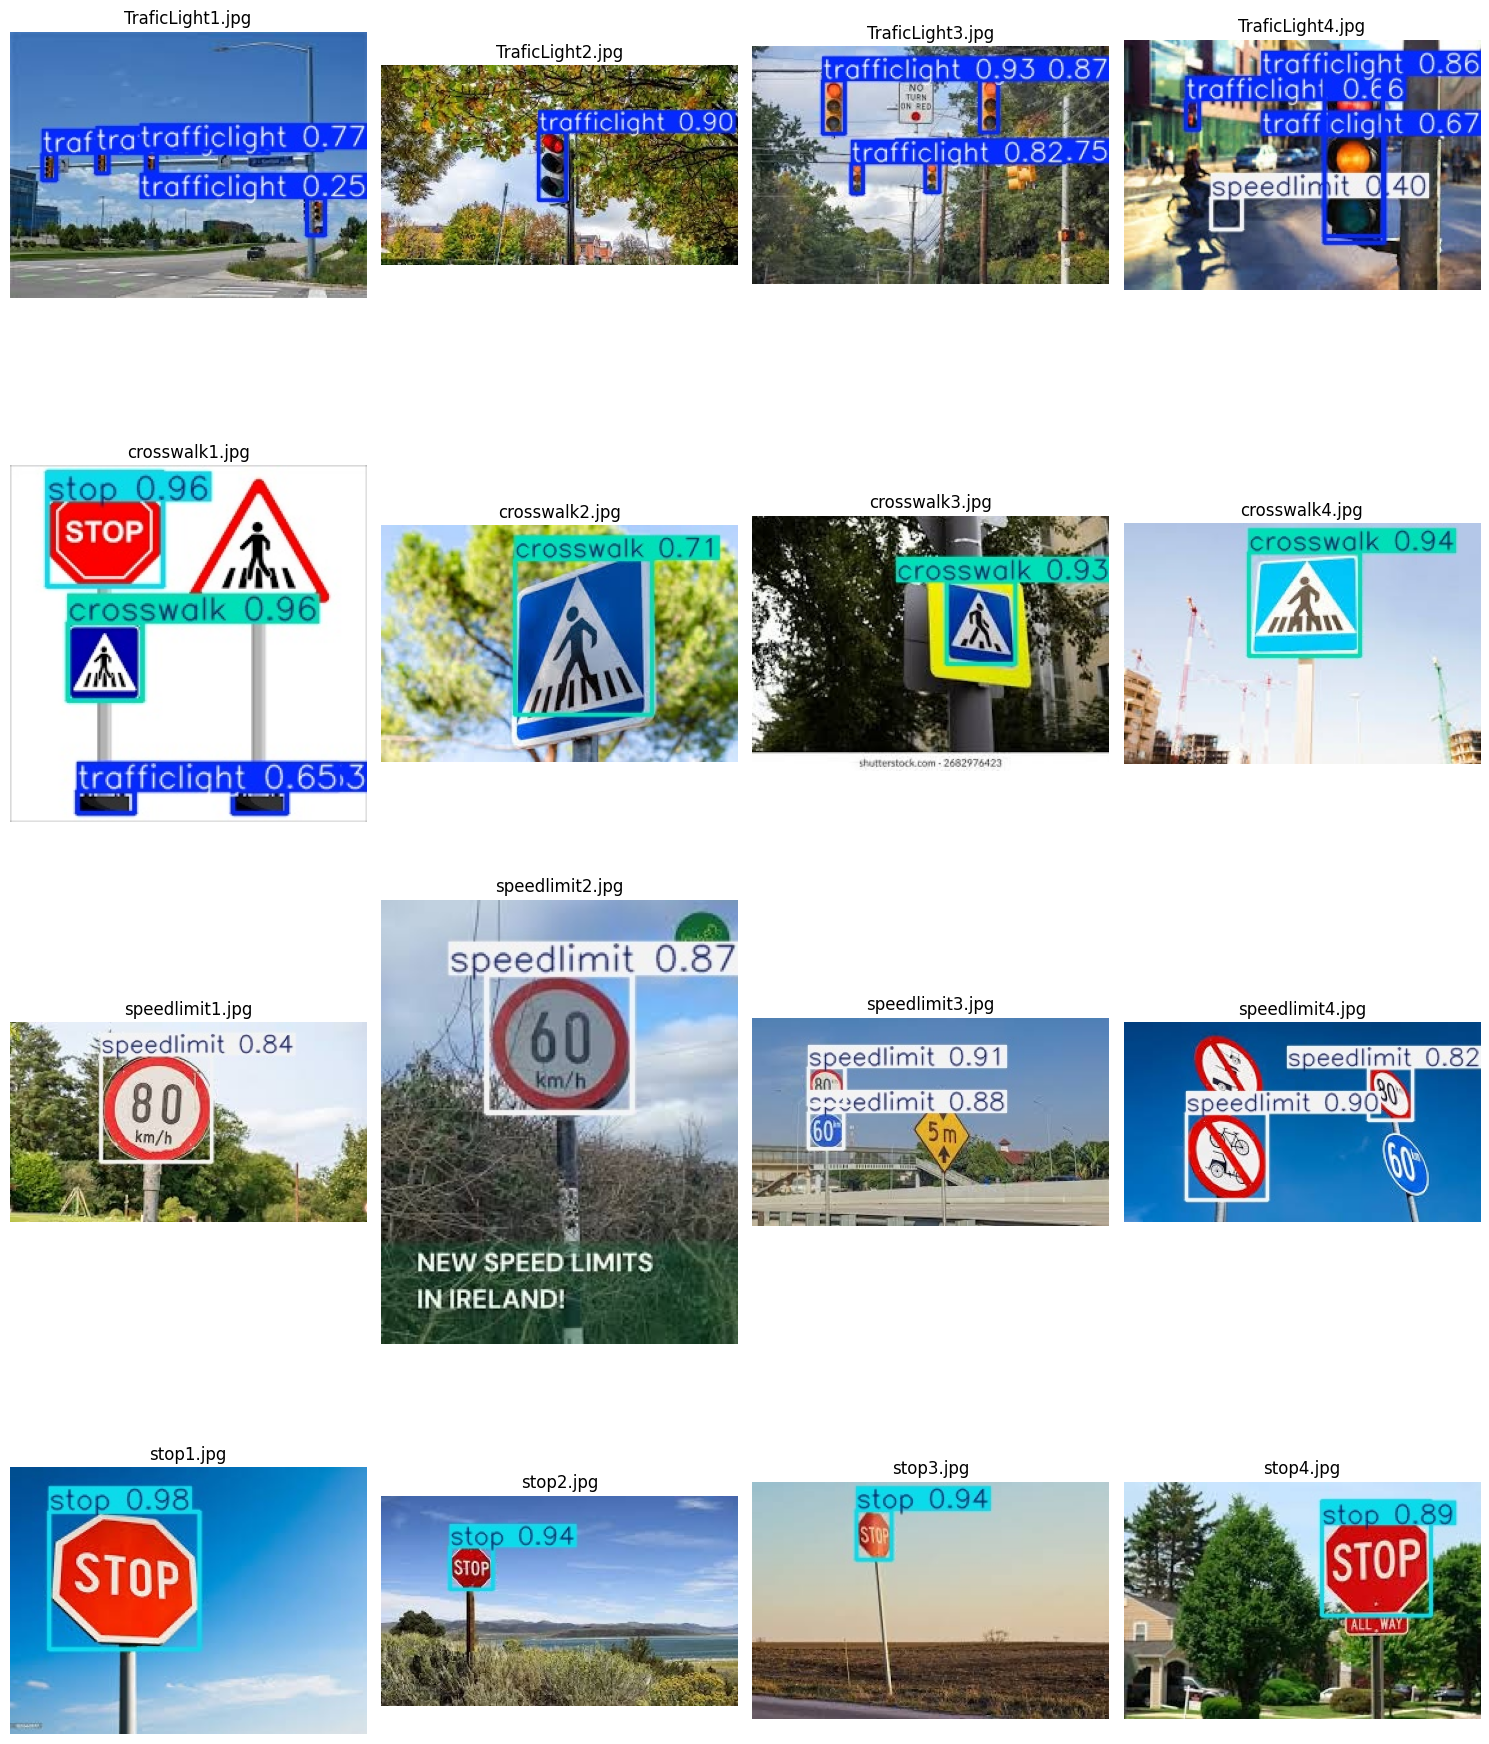

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

# 1. 이미지 파일 경로 설정
imagefolder_path = '/content/roadsign_datasets/runs/detect/predict'

# 파일 가져오기
img_paths = sorted(glob.glob(os.path.join(imagefolder_path, '*.jpg')))
num_imgs = len(img_paths)

if num_imgs == 0:
    print("경로에 이미지가 없습니다. 경로를 다시 확인해주세요.")
else:
    # [수정 1] 4행 3열로 설정 (총 12개 칸)
    # figsize를 (15, 20) 정도로 키워야 각각의 이미지가 크게 보입니다.
    fig, axes = plt.subplots(4, 4, figsize=(15, 20))

    # [수정 2] axes가 2차원 배열(4x3)이므로, 1차원 리스트로 펼쳐줍니다.
    # 이렇게 해야 zip이나 반복문을 돌리기 편합니다.
    flat_axes = axes.flatten()

    # [수정 3] enumerate를 사용하여 빈 칸 처리까지 고려
    for i, ax in enumerate(flat_axes):
        if i < num_imgs:
            # 이미지가 있는 경우
            img_path = img_paths[i]
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(os.path.basename(img_path))
            ax.axis('off')
        else:
            # 이미지가 12장보다 적어서 남는 칸이 있다면 빈칸으로 숨김 처리
            ax.axis('off')

    plt.tight_layout()
    plt.show()